In [1]:
#%matplotlib notebook
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from adaptive_sampling.processing_tools.mbar import *
from adaptive_sampling.processing_tools.thermodynamic_integration import *

font = {'family': 'serif',
        'weight': 'normal',
        'size': 22,
        }
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
def P1(x):
    
    a = 8.0e-6
    d = 80.0
    e = 160.0

    s1 = (x-d)*(x-d)
    s2 = (x-e)*(x-e)

    return a * s1*s2

In [3]:
def P1_2d(x, y):
    
    a = 8.0e-6
    b = 0.5
    d = 80.0
    e = 160.0

    s1 = (x-d)*(x-d)
    s2 = (x-e)*(x-e)

    return a * s1*s2 + b*y*y

In [4]:
x = np.arange(60,181,1.0)
y = np.arange(-8,8,0.1)
xx,yy = np.meshgrid(x,y)

FES_2D = P1_2d(xx,yy)
R = 8.314 / 1000.0  # kJ / K mol

RT = (R * 300.0) / 1000.0
RHO_2D = np.exp(-FES_2D/RT)
RHO_2D /= RHO_2D.sum()

In [5]:
traj_dat = np.loadtxt('CV_traj.dat', skiprows=1)
output = np.loadtxt('md_eabf.out', skiprows=10)

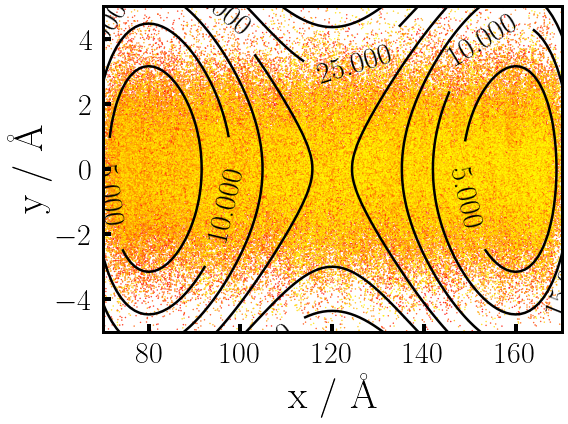

In [6]:
plt.rcParams["figure.figsize"] = [8,6]
fig, axs = plt.subplots(ncols=1)
#
t = np.arange(0,len(output),10)
plt.scatter(output[::10,1], output[::10,2], s=0.2, c=t, cmap='autumn', zorder=0)

CS = axs.contour(xx, yy, FES_2D, colors='black', levels=12, linewidths=2.5, zorder=1)
plt.clabel(CS, CS.levels, inline='true', fontsize=30, fmt="%5.3f")

axs.tick_params(axis='y',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.tick_params(axis='x',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.set_ylabel('y / \AA', fontsize=40)
axs.set_xlabel('x / \AA', fontsize=40)
axs.set_xlim([70,170])
axs.set_ylim([-5,5])

axs.spines['bottom'].set_linewidth('3')
axs.spines['top'].set_linewidth('3')
axs.spines['left'].set_linewidth('3')
axs.spines['right'].set_linewidth('3')
fig.tight_layout()
#plt.savefig("figure_1a.pdf")
plt.show()
plt.close()

In [7]:
sigma = 2.0
dx = 2.0
grid = np.arange(70.0, 170.0, dx)

# combine both walkers
t  = traj_dat[:,0]/1000000
cv = traj_dat[:,1] # reaction coordinate
la = traj_dat[:,2] # extended system

data = {'t': t, 'cv': cv, 'la': la}
df = pd.DataFrame(data)

#sns.set_style("ticks")
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,6), gridspec_kw=dict(width_ratios=[3,0.5]))

sns.lineplot(data=df, y='cv', x='t', ax=axs[0], label=r'$\xi$')
sns.lineplot(data=df, y='la', x='t', ax=axs[0], label=r'$\lambda$')
sns.distplot(df["cv"], bins=grid, ax=axs[1], vertical=True, hist=True, norm_hist=True, axlabel=False)
sns.distplot(df["la"], bins=grid, ax=axs[1], vertical=True, hist=True, norm_hist=True, axlabel=False)

axs[0].set_xlabel('time / ns', fontsize=40)
axs[0].set_ylabel(r'$z$ / \AA', fontsize=40)
axs[0].set_xlim([0,10])
axs[0].set_ylim([70,174])
axs[0].legend(fontsize=30, frameon=True, shadow=True, loc='upper right')
axs[1].set_xlabel('Density', fontsize=40)
axs[1].set_xlim([0,0.02])

for ax in axs:
    ax.tick_params(axis='x',length=6,width=3,labelsize=30, pad=10, direction='in')
    ax.tick_params(axis='y',length=6,width=3,labelsize=30, pad=10, direction='in')
    #ax.grid()
    ax.spines['bottom'].set_linewidth('3')
    ax.spines['top'].set_linewidth('3')
    ax.spines['left'].set_linewidth('3')
    ax.spines['right'].set_linewidth('3')

fig.tight_layout()
#fig.savefig('figure_1b.pdf')
plt.show()
plt.close()

In [8]:
# bootstrapping pmf with MBAR
pmf_list = []
idx = np.arange(0,len(cv))
exact = P1(grid)
rmsd_list = []

for i in range(1): #100): # slow!
    boot = resample(idx, replace=True, n_samples=len(cv))
    cv_i = cv[boot]
    la_i = la[boot]
    traj_list, indices, meta_f = get_windows(grid, cv_i, la_i, sigma, equil_temp=300.0)
    W_i = mbar(traj_list, meta_f, conv=1.0e-4, conv_errvec=None, outfreq=100, equil_temp=300.0)
    pmf_i, _ = pmf_from_weights(grid, cv_i[indices], W_i, equil_temp=300.0)
    pmf_i -= pmf_i.min()
    pmf_list.append(pmf_i)
    rmsd_list.append(np.linalg.norm(pmf_i[1:-1]-exact[1:-1]) / np.sqrt(len(pmf_i[1:-1])))
    if i % 10 == 0:
        print('%3d done' % i)

pmf_list = np.asarray(pmf_list)
pmf_mean_boot = pmf_list.mean(axis=0)
pmf_std_boot = pmf_list.std(axis=0)

Making Boltzmann factors

All ready!

Start of the self-consistent iteration.
Iter    1:	Conv=  0.9207067831	Max(errorvec):6612.1415875360
Iter  100:	Conv=  0.0262698687	Max(errorvec):582.7805016621
Iter  200:	Conv=  0.0053597685	Max(errorvec):114.8241877934
Iter  300:	Conv=  0.0011761805	Max(errorvec): 26.6556211875
Iter  400:	Conv=  0.0003229259	Max(errorvec):  8.5421805802
Iter  500:	Conv=  0.0001429202	Max(errorvec):  3.8931504756
Converged after 588 iterations!
Max error vector: 2.3818921947386116
  0 done


In [12]:
# bootstrapping pmf with CZAR/TI
czar_list = []
idx = np.arange(0,len(cv))
exact = P1(grid+dx)
rmsd_list = []

for i in range(100):
    boot = resample(idx, replace=True, n_samples=len(cv))
    cv_i = cv[boot]
    la_i = la[boot]
    czar_i = czar(grid, cv_i, la_i, sigma, equil_temp=300.0)
    czar_i, _ = integrate(czar_i, dx, equil_temp=300.0)
    czar_i -= czar_i.min()
    czar_list.append(czar_i)
    rmsd_list.append(np.linalg.norm(czar_i[1:-1]-exact[1:-1]) / np.sqrt(len(czar_i[1:-1])))
    if i % 10 == 0:
        print('%3d done' % i)

czar_list = np.asarray(czar_list)
czar_mean_boot = czar_list.mean(axis=0)
czar_std_boot = czar_list.std(axis=0)

  0 done
 10 done
 20 done
 30 done
 40 done
 50 done
 60 done
 70 done
 80 done
 90 done


In [13]:
dat = np.loadtxt('eabf.out', skiprows=1)

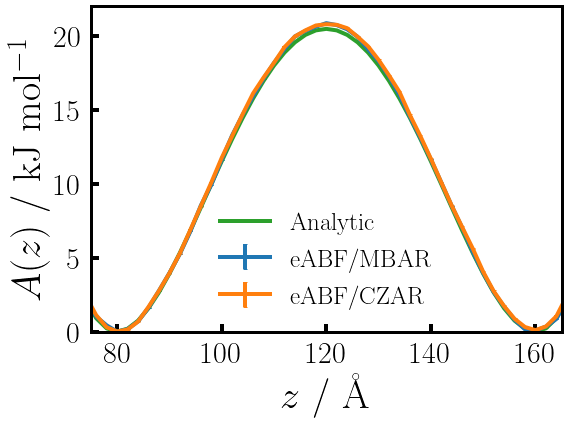

In [16]:
fig, axs = plt.subplots(1, figsize=(8,6))
exact = P1(grid)

axs.errorbar(grid, pmf_mean_boot, yerr=pmf_std_boot, capsize=2, linewidth=4, label=r'eABF/MBAR')
axs.errorbar(grid+dx, czar_mean_boot, yerr=czar_std_boot, capsize=2, linewidth=4, label='eABF/CZAR')
axs.plot(grid, exact, linewidth=4, label=r'Analytic')
#axs.plot(dat[:,0]+1.0, dat[:,2], linewidth=6, label=r'on-the-fly')

axs.set_ylim([0,22])
axs.set_xlim([75.0,165.0])
axs.tick_params(axis='y',length=8,width=4,labelsize=30, pad=10, direction='in')
axs.tick_params(axis='x',length=8,width=4,labelsize=30, pad=10, direction='in')
#axs.grid()
axs.legend(fontsize=25, loc='best', frameon=False, shadow=False)
axs.set_xlabel(r'$z$ / \AA', fontsize=40)
axs.set_ylabel(r'$A(z)$ / kJ mol$^{-1}$', fontsize=40)
axs.spines['bottom'].set_linewidth('3')
axs.spines['top'].set_linewidth('3')
axs.spines['left'].set_linewidth('3')
axs.spines['right'].set_linewidth('3')

fig.tight_layout()
#fig.savefig('free_energy_p1.pdf')
plt.show()
plt.close()